In [24]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import string
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import matplotlib.image as mpimg
from nltk.translate.bleu_score import sentence_bleu
import pickle

In [2]:
tf.version.VERSION

'2.2.0'

In [3]:
val_images = np.load("val_img.npy",allow_pickle=True)
val_actual = np.load("val_actual.npy",allow_pickle=True)

In [4]:
val_images[0], val_actual[0]

(array(['CXR2978_IM-1367-4001.png', 'CXR2978_IM-1367-1001.png'],
       dtype=object), '<start> no acute findings <end>')

In [5]:
#Unzip the uploaded files, folder names are same for zip file name
tokenizer = pickle.load(open("tokenizer.pkl", 'rb'))
decoder = tf.saved_model.load('decoder/')
encoder = tf.saved_model.load('encoder/')

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import os
image_features_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
image_features_model.load_weights("trained_weights-07-0.9102.hdf5")

In [7]:
#Provide image path
image_path = "img/"

In [8]:
max_len_output =80
units = 128

In [9]:
def get_img_tensor(image_path, img_name, model_image):
    img = tf.io.read_file(image_path + str(img_name))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = preprocess_input(img)
    img_features = model_image(tf.constant(img)[None, :])
    return img_features

In [10]:
def calculate_score(x):
    """Calculates the cumulative score for the length of sentence"""
    return x[1]/len(x[0])

def beam_search(img_name, beam_index = 3):
    """Beam search implementaion takes images as input"""
    hidden =  tf.zeros((1, units))
    img_tensor = tf.convert_to_tensor([get_img_tensor(image_path,img_name[0], image_features_model), 
                                      get_img_tensor(image_path,img_name[1], image_features_model)])
    img_features = tf.constant(img_tensor)[None, :]
    features_val = encoder(img_features)
    start = [tokenizer.word_index["<start>"]]
    dec_word = [[start, 0.0]]
    while len(dec_word[0][0]) < max_len_output:
        temp = []
        for s in dec_word:
            predictions, hidden = decoder([tf.cast(tf.expand_dims([s[0][-1]], 0), tf.float32), features_val, hidden])

            word_preds = np.argsort(predictions[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += predictions[0][w]
                temp.append([next_cap, prob.numpy()])
        dec_word = temp
        # Sorting according to the probabilities scores
        dec_word = sorted(dec_word, reverse=False, key=calculate_score)
        # Getting the top words
        dec_word = dec_word[-beam_index:]
    dec_word = dec_word[-1][0]
    impression = [tokenizer.index_word[i] for i in dec_word if i !=0]
    result = []
    
    for i in impression:
        if i != '<end>':
            result.append(i)
        else:
            break
    
    text = ' '.join(result[1:])
    return result, text

In [203]:
columns = ["idx", "image_1", "image_2", "actual", "predicted", "score"]
df = pd.DataFrame(columns = columns)
for i in tqdm(range(len(val_images))):
    result, text_predicted = beam_search(val_images[i])
    actual = ' '.join([str(elem) for elem in val_actual[i].split()[1:-1]])
    predicted = ' '.join([str(elem) for elem in result[1:]])
    df = df.append(pd.Series([i, val_images[i][0], val_images[i][1], actual, predicted, sentence_bleu([val_actual[i].split()[1:-1]], result[1:], weights=(1, 0, 0, 0))], index = columns), ignore_index = True)
df.head(20)

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [07:17<00:00,  1.10s/it]


,idx,image_1,image_2,actual,predicted,score
0,0,CXR2978_IM-1367-4001.png,CXR2978_IM-1367-1001.png,no acute findings,no evidence of prior excluded could be identified,0.125000
1,1,CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png,no acute disease,no cardiopulmonary abnormalities,0.333333
2,2,CXR3953_IM-2021-1002.png,CXR3953_IM-2021-1001.png,no acute cardiopulmonary abnormality,no evidence of pleural disease,0.200000
3,3,CXR3227_IM-1525-1001.png,CXR3227_IM-1525-2001.png,no acute cardiopulmonary process,no cardiopulmonary abnormalities,0.477688
4,4,CXR2820_IM-1244-1001.png,CXR2820_IM-1244-2001.png,no acute disease,no cardiopulmonary disease,0.666667
5,5,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,no pneumonia heart size normal scoliosis,no evidence for pulmonary nodules of the bone ...,0.041667
6,6,CXR1510_IM-0331-2001.png,CXR1510_IM-0331-1001.png,no acute cardiopulmonary abnormality,no acute abnormalities,0.477688
7,7,CXR979_IM-2466-2001.png,CXR979_IM-2466-1001.png,negative for acute abnormality,no evidence for consolidation,0.250000
8,8,CXR3662_IM-1821-1001.png,CXR3662_IM-1821-2001.png,chest radiograph no acute radiographic cardiop...,no evidence of primordial,0.118092
9,9,CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-2001-0002.png,right upper lobe mass suspicious for neoplasm ...,no cardiopulmonary abnormalities,0.000000


In [206]:
df_poor = df[df['score'] < 0.08]

In [207]:
df_poor.head()

,idx,image_1,image_2,actual,predicted,score
5,5,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,no pneumonia heart size normal scoliosis,no evidence for pulmonary nodules of the bone ...,0.041667
9,9,CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-2001-0002.png,right upper lobe mass suspicious for neoplasm ...,no cardiopulmonary abnormalities,0.000000
10,10,CXR1418_IM-0267-1001.png,CXR1418_IM-0267-2002.png,no comparison chest x wellexpanded and clear l...,no evidence for disease,0.007549
13,13,CXR3427_IM-1657-1001.png,CXR3427_IM-1657-2001.png,there is no evidence of acute cardiopulmonary ...,no acute findings,0.012210
18,18,CXR1701_IM-0462-2001.png,CXR1701_IM-0462-1001.png,no acute findings,low lung effusion,0.000000


In [208]:
df_poor['duplicate'] = np.where(df_poor['image_1']==df_poor['image_2'], 1, 0)

In [209]:
df_poor.head()

,idx,image_1,image_2,actual,predicted,score,duplicate
5,5,CXR1029_IM-0022-1001.png,CXR1029_IM-0022-1001.png,no pneumonia heart size normal scoliosis,no evidence for pulmonary nodules of the bone ...,0.041667,1
9,9,CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-2001-0002.png,right upper lobe mass suspicious for neoplasm ...,no cardiopulmonary abnormalities,0.000000,0
10,10,CXR1418_IM-0267-1001.png,CXR1418_IM-0267-2002.png,no comparison chest x wellexpanded and clear l...,no evidence for disease,0.007549,0
13,13,CXR3427_IM-1657-1001.png,CXR3427_IM-1657-2001.png,there is no evidence of acute cardiopulmonary ...,no acute findings,0.012210,0
18,18,CXR1701_IM-0462-2001.png,CXR1701_IM-0462-1001.png,no acute findings,low lung effusion,0.000000,0


In [210]:
df_poor['duplicate'].value_counts()

0    139
1     22
Name: duplicate, dtype: int64

- There are 22 duplicate image data which predicted score is poor as we already know that these data points we considered as noise and equally split among all the data sets.
- Lets ignore those data points in the prediction and perform a analysis from start

In [11]:
columns = ["idx", "image_1", "image_2", "actual", "predicted", "score"]
df1 = pd.DataFrame(columns = columns)
for i in tqdm(range(len(val_images))):
    if val_images[i][0] != val_images[i][1]:
        result, text_predicted = beam_search(val_images[i])
        actual = ' '.join([str(elem) for elem in val_actual[i].split()[1:-1]])
        predicted = ' '.join([str(elem) for elem in result[1:]])
        df1 = df1.append(pd.Series([i, val_images[i][0], val_images[i][1], actual, predicted, sentence_bleu([val_actual[i].split()[1:-1]], result[1:], weights=(1, 0, 0, 0))], index = columns), ignore_index = True)
df1.head(20)

100%|████████████████████████████████████████████████████████████████████████████████| 399/399 [09:51<00:00,  1.48s/it]


,idx,image_1,image_2,actual,predicted,score
0,0,CXR2978_IM-1367-4001.png,CXR2978_IM-1367-1001.png,no acute findings,no evidence of prior excluded could be identified,0.125000
1,1,CXR58_IM-2177-2001.png,CXR58_IM-2177-1001.png,no acute disease,no cardiopulmonary abnormalities,0.333333
2,2,CXR3953_IM-2021-1002.png,CXR3953_IM-2021-1001.png,no acute cardiopulmonary abnormality,no evidence of pleural disease,0.200000
3,3,CXR3227_IM-1525-1001.png,CXR3227_IM-1525-2001.png,no acute cardiopulmonary process,no cardiopulmonary abnormalities,0.477688
4,4,CXR2820_IM-1244-1001.png,CXR2820_IM-1244-2001.png,no acute disease,no cardiopulmonary disease,0.666667
5,6,CXR1510_IM-0331-2001.png,CXR1510_IM-0331-1001.png,no acute cardiopulmonary abnormality,no acute abnormalities,0.477688
6,7,CXR979_IM-2466-2001.png,CXR979_IM-2466-1001.png,negative for acute abnormality,no evidence for consolidation,0.250000
7,8,CXR3662_IM-1821-1001.png,CXR3662_IM-1821-2001.png,chest radiograph no acute radiographic cardiop...,no evidence of primordial,0.118092
8,9,CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-2001-0002.png,right upper lobe mass suspicious for neoplasm ...,no cardiopulmonary abnormalities,0.000000
9,10,CXR1418_IM-0267-1001.png,CXR1418_IM-0267-2002.png,no comparison chest x wellexpanded and clear l...,no evidence for disease,0.007549


__Lets visualize the good results images__

In [12]:
df1_best = df1[df1['score'] > 0.5]
df1_best.head()

,idx,image_1,image_2,actual,predicted,score
4,4,CXR2820_IM-1244-1001.png,CXR2820_IM-1244-2001.png,no acute disease,no cardiopulmonary disease,0.666667
10,11,CXR1005_IM-0006-1001.png,CXR1005_IM-0006-3003.png,no acute findings,no acute findings,1.000000
21,23,CXR3735_IM-1866-2001.png,CXR3735_IM-1866-1001.png,no acute process,no acute cardiopulmonary process,0.750000
28,30,CXR3204_IM-1513-2001.png,CXR3204_IM-1513-1001.png,no acute pulmonary disease,no acute airspace disease,0.750000
44,51,CXR179_IM-0514-2001.png,CXR179_IM-0514-1001.png,no acute cardiopulmonary abnormality,no acute cardiopulmonary abnormality,1.000000


In [13]:
df_sorted = df1.sort_values('score', ascending=False)
df_sorted.head()

,idx,image_1,image_2,actual,predicted,score
44,51,CXR179_IM-0514-2001.png,CXR179_IM-0514-1001.png,no acute cardiopulmonary abnormality,no acute cardiopulmonary abnormality,1.00
10,11,CXR1005_IM-0006-1001.png,CXR1005_IM-0006-3003.png,no acute findings,no acute findings,1.00
56,64,CXR2658_IM-1140-2001.png,CXR2658_IM-1140-1001.png,no acute cardiopulmonary abnormalities,no acute cardiopulmonary disease,0.75
348,392,CXR1780_IM-0509-2001.png,CXR1780_IM-0509-1001.png,no acute cardiopulmonary abnormality,no acute cardiopulmonary process,0.75
21,23,CXR3735_IM-1866-2001.png,CXR3735_IM-1866-1001.png,no acute process,no acute cardiopulmonary process,0.75


In [14]:
len(df_sorted[df_sorted['score'] < 0.08])

139

In [15]:
139/354

0.3926553672316384

39% of the data seems having poor bleu score. Lets take the those data points and do some analysis

In [16]:
df_poor = df_sorted[df_sorted['score'] < 0.08]
df_poor.head()

,idx,image_1,image_2,actual,predicted,score
301,341,CXR1562_IM-0367-2001.png,CXR1562_IM-0367-1001.png,negative for acute cardiopulmonary abnormality,no acute subsegmental streaky airways pulmonar...,0.071429
26,28,CXR219_IM-0799-2001.png,CXR219_IM-0799-1001.png,no x evidence of pulmonary metastatic disease ...,no evidence for consolidation,0.067668
54,62,CXR1485_IM-0313-1001.png,CXR1485_IM-0313-2001.png,unchanged platelike bibasilar opacities most r...,low lung characterized within the body acute f...,0.067032
46,53,CXR594_IM-2187-1001.png,CXR594_IM-2187-2001.png,borderline cardiomegaly ageindeterminate chron...,low lung sequela of the heart this is within n...,0.066667
304,344,CXR300_IM-1385-1001.png,CXR300_IM-1385-1002.png,changes of chronic lung disease with no acute ...,no acute abnormalities,0.064648


In [17]:
df_poor['actual_count'] = df_poor['actual'].astype(str).str.split().apply(lambda x: 0 if x==None else len(x))
df_poor.head()

,idx,image_1,image_2,actual,predicted,score,actual_count
301,341,CXR1562_IM-0367-2001.png,CXR1562_IM-0367-1001.png,negative for acute cardiopulmonary abnormality,no acute subsegmental streaky airways pulmonar...,0.071429,5
26,28,CXR219_IM-0799-2001.png,CXR219_IM-0799-1001.png,no x evidence of pulmonary metastatic disease ...,no evidence for consolidation,0.067668,12
54,62,CXR1485_IM-0313-1001.png,CXR1485_IM-0313-2001.png,unchanged platelike bibasilar opacities most r...,low lung characterized within the body acute f...,0.067032,14
46,53,CXR594_IM-2187-1001.png,CXR594_IM-2187-2001.png,borderline cardiomegaly ageindeterminate chron...,low lung sequela of the heart this is within n...,0.066667,9
304,344,CXR300_IM-1385-1001.png,CXR300_IM-1385-1002.png,changes of chronic lung disease with no acute ...,no acute abnormalities,0.064648,10


In [18]:
df_poor.shape

(139, 7)

In [19]:
df_poor['actual_count'].describe()

count    139.000000
mean      17.532374
std       14.668957
min        2.000000
25%        5.500000
50%       14.000000
75%       25.500000
max      110.000000
Name: actual_count, dtype: float64

- minimum is 2 and the maximum word count is 110. we have used the max_len as 80 in our prediction lets ignore those word counts which are greater than 80.

In [20]:
df_poor = df_poor[df_poor['actual_count'] < 80]
df_poor.shape

(138, 7)

__Lets take each data point and do the analysis__

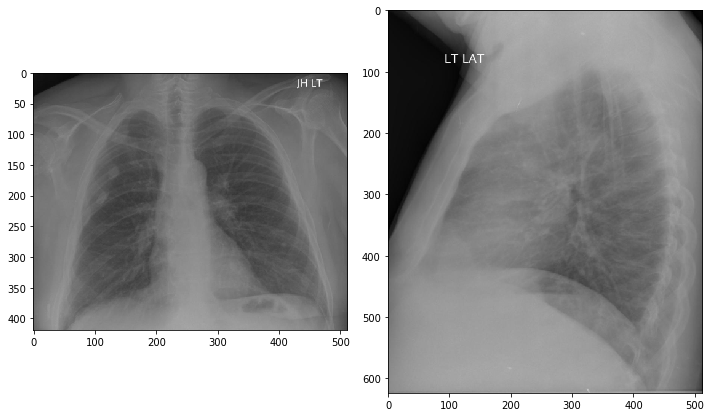

Score: 0.0004681758116527773
Actual: stable normal cardiac size and contour unremarkable mediastinal silhouette normal pulmonary and interstitium lungs clear no airspace disease pleural effusion or pneumothorax no activeacute cardiopulmonary disease
Predicted: no cardiopulmonary disease
word count: 26


In [149]:
k=random.choice(df_poor.index.tolist())
img_nms = [df_poor["image_1"][k], df_poor["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score:", df_poor["score"][k])
print("Actual:", df_poor["actual"][k])
print("Predicted:", df_poor["predicted"][k])
print("word count:", df_poor["actual_count"][k])

- word length is 26 and there is a word overlap __"activeacute"__ in actual value could not find any image issue
- Predicted word gives the partial meaning from the actual not a poor prediction. 
- we get the poor value because Bleu score does not accounts the meaning

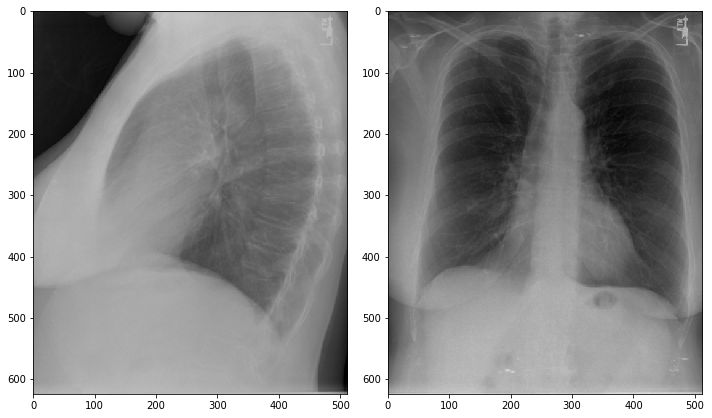

Score: 0.0
Actual: small right juxtahilar opacity may represent infiltrate in the setting of followup chest x is recommended at an appropriate interval following treatment to document
Predicted: no acute abnormalities
word count: 24


In [150]:
import random
k=random.choice(df_poor.index.tolist())
img_nms = [df_poor["image_1"][k], df_poor["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score:", df_poor["score"][k])
print("Actual:", df_poor["actual"][k])
print("Predicted:", df_poor["predicted"][k])
print("word count:", df_poor["actual_count"][k])

- word count is 24, No error in actual word. still cant find any image wise pattern issue
- predicted word is poor did not give any similar meanings

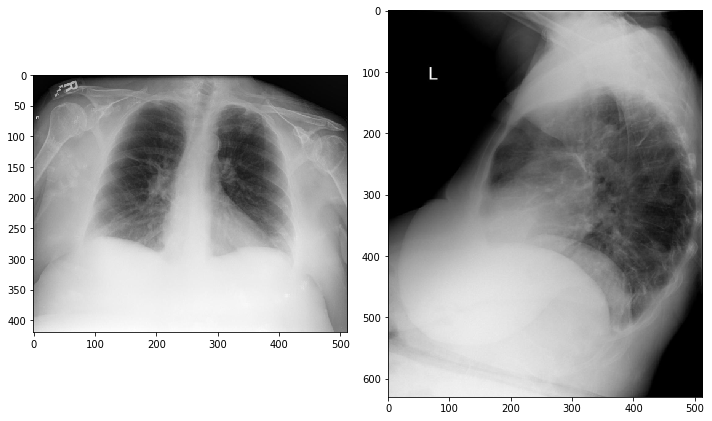

Score: 0.0
Actual: no focal air space consolidation nodular opacity at the left apex may be exaggerated by overlapping bone silhouettes chest may provide further evaluation if warranted
Predicted: low lung features without acute follow critical result of thoracic spine portacatheter
word count: 25


In [151]:
import random
k=random.choice(df_poor.index.tolist())
img_nms = [df_poor["image_1"][k], df_poor["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score:", df_poor["score"][k])
print("Actual:", df_poor["actual"][k])
print("Predicted:", df_poor["predicted"][k])
print("word count:", df_poor["actual_count"][k])

- word count is 25, no error in actual word, no image patter issue could be identified
- predicted is poor did not give any meaning from actual.

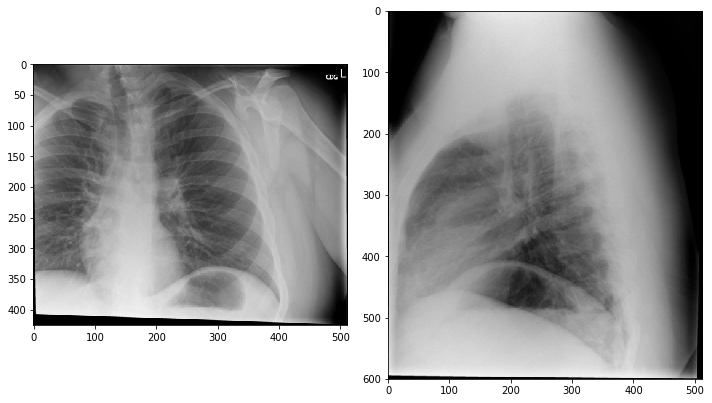

Score: 0.04632230081520103
Actual: chest no visible active cardiopulmonary disease left hip advanced posttraumatic osteoarthritis
Predicted: no cardiopulmonary abnormalities
word count: 11


In [153]:
import random
k=random.choice(df_poor.index.tolist())
img_nms = [df_poor["image_1"][k], df_poor["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score:", df_poor["score"][k])
print("Actual:", df_poor["actual"][k])
print("Predicted:", df_poor["predicted"][k])
print("word count:", df_poor["actual_count"][k])

- word count is 11, No error in actual word, images is not perfectly captured when we compare with other.
- Prediction gives same meaning, issue with the Bleu score and images.

__As we can see the bleu score which is having value greater than 0 actually gives the partial meaning of actual which considered as good prediction lets take bleu score which are 0.__  
__Another finding is when we have word more than 20 word give 0 values. which shows that our model did not perform well for longer sentence. lets consider word lesser than 20.__

In [21]:
df_poor_zero = df_poor[df_poor['score'] == 0]
df_poor_zero.head()

,idx,image_1,image_2,actual,predicted,score,actual_count
49,56,CXR2716_IM-1181-1001.png,CXR2716_IM-1181-2001.png,right lower lobe airspace disease with bilater...,no cardiopulmonary abnormalities,0.0,9
352,397,CXR1013_IM-0013-1001.png,CXR1013_IM-0013-2001.png,stable mild cardiomegaly without acute cardiop...,no evidence of pulmonary venous hypertension,0.0,7
184,211,CXR1304_IM-0199-2001.png,CXR1304_IM-0199-1001.png,normal chest,no acute findings,0.0,2
204,232,CXR501_IM-2120-2001.png,CXR501_IM-2120-1001.png,there is minimal streaky opacity in the poster...,low lung features consistent,0.0,24
203,230,CXR2943_IM-1343-1001.png,CXR2943_IM-1343-4004.png,mild left costophrenic blunting basilar pleura...,no cardiopulmonary abnormalities,0.0,42


In [22]:
df_poor_zero = df_poor_zero[df_poor_zero['actual_count'] < 20]
df_poor_zero.head()

,idx,image_1,image_2,actual,predicted,score,actual_count
49,56,CXR2716_IM-1181-1001.png,CXR2716_IM-1181-2001.png,right lower lobe airspace disease with bilater...,no cardiopulmonary abnormalities,0.0,9
352,397,CXR1013_IM-0013-1001.png,CXR1013_IM-0013-2001.png,stable mild cardiomegaly without acute cardiop...,no evidence of pulmonary venous hypertension,0.0,7
184,211,CXR1304_IM-0199-2001.png,CXR1304_IM-0199-1001.png,normal chest,no acute findings,0.0,2
208,236,CXR2922_IM-1325-12012.png,CXR2922_IM-1325-1001.png,hyperinflated lungs air trapping versus inspir...,low lung features are elevation,0.0,6
8,9,CXR1303_IM-0199-2001-0001.png,CXR1303_IM-0199-2001-0002.png,right upper lobe mass suspicious for neoplasm ...,no cardiopulmonary abnormalities,0.0,19


In [166]:
df_poor_zero.shape

(62, 7)

==== Displaying best result random 25 patient X-Ray 1st image ====


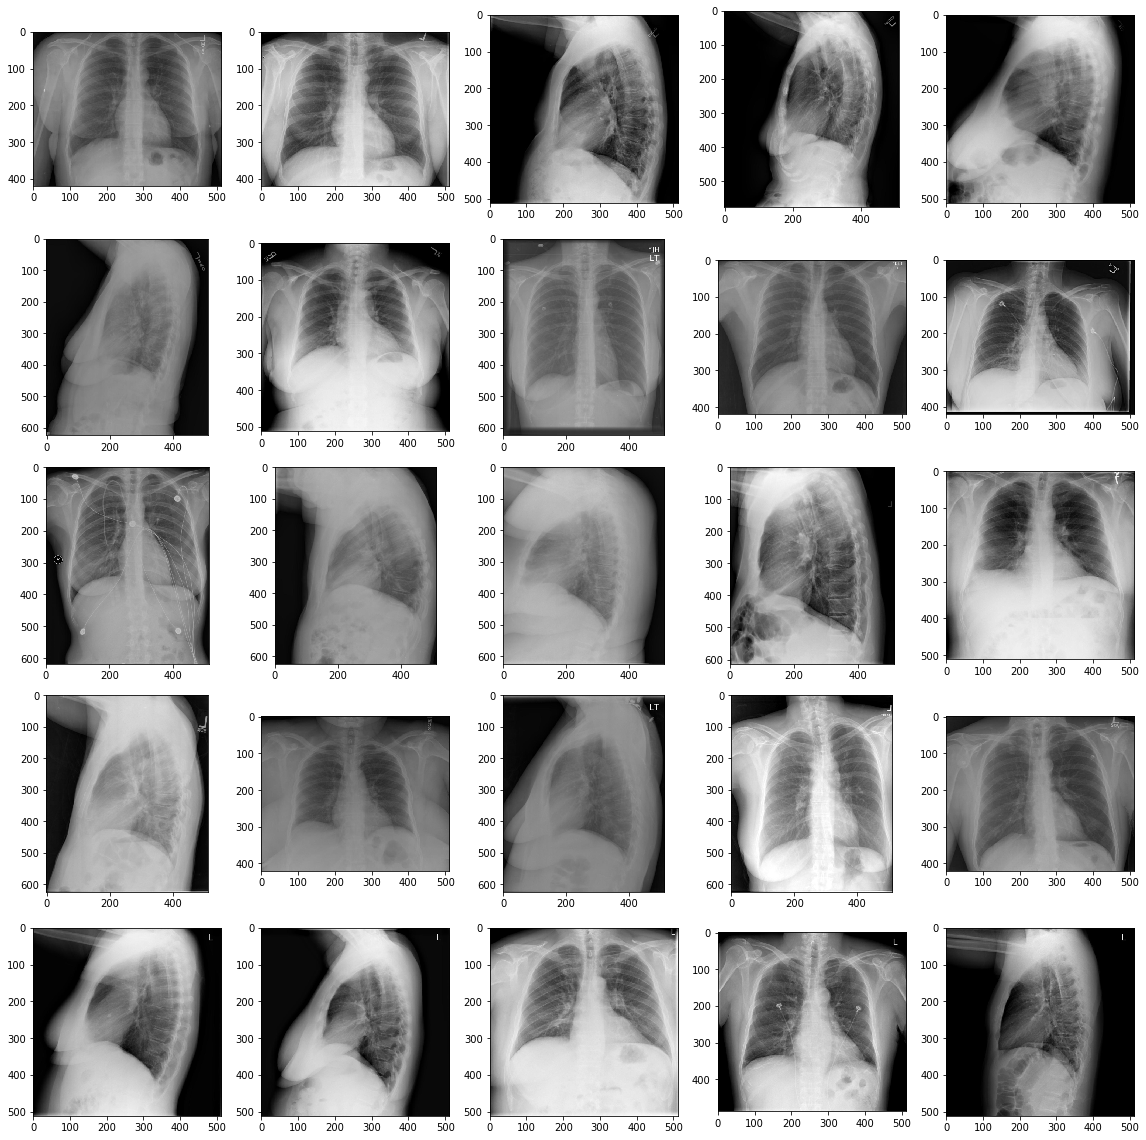

In [175]:
print("==== Displaying best result random 25 patient X-Ray 1st image ====")
fig, axs = plt.subplots(5, 5, figsize = (16,16), tight_layout=True)
for row, subplot in zip(df1_best[0:25].itertuples(), axs.flatten()):
    img=mpimg.imread(image_path+row.image_1)
    subplot.imshow(img, cmap = 'bone')
plt.show()

__Points to take in best result images__
- proper alignment of images
- brighter view of chest bones
- does not have any additional dark line
- Even in the dull images we could clearly see the chest bones

==== Displaying worst case result random 25 patient X-Ray 1st image ====


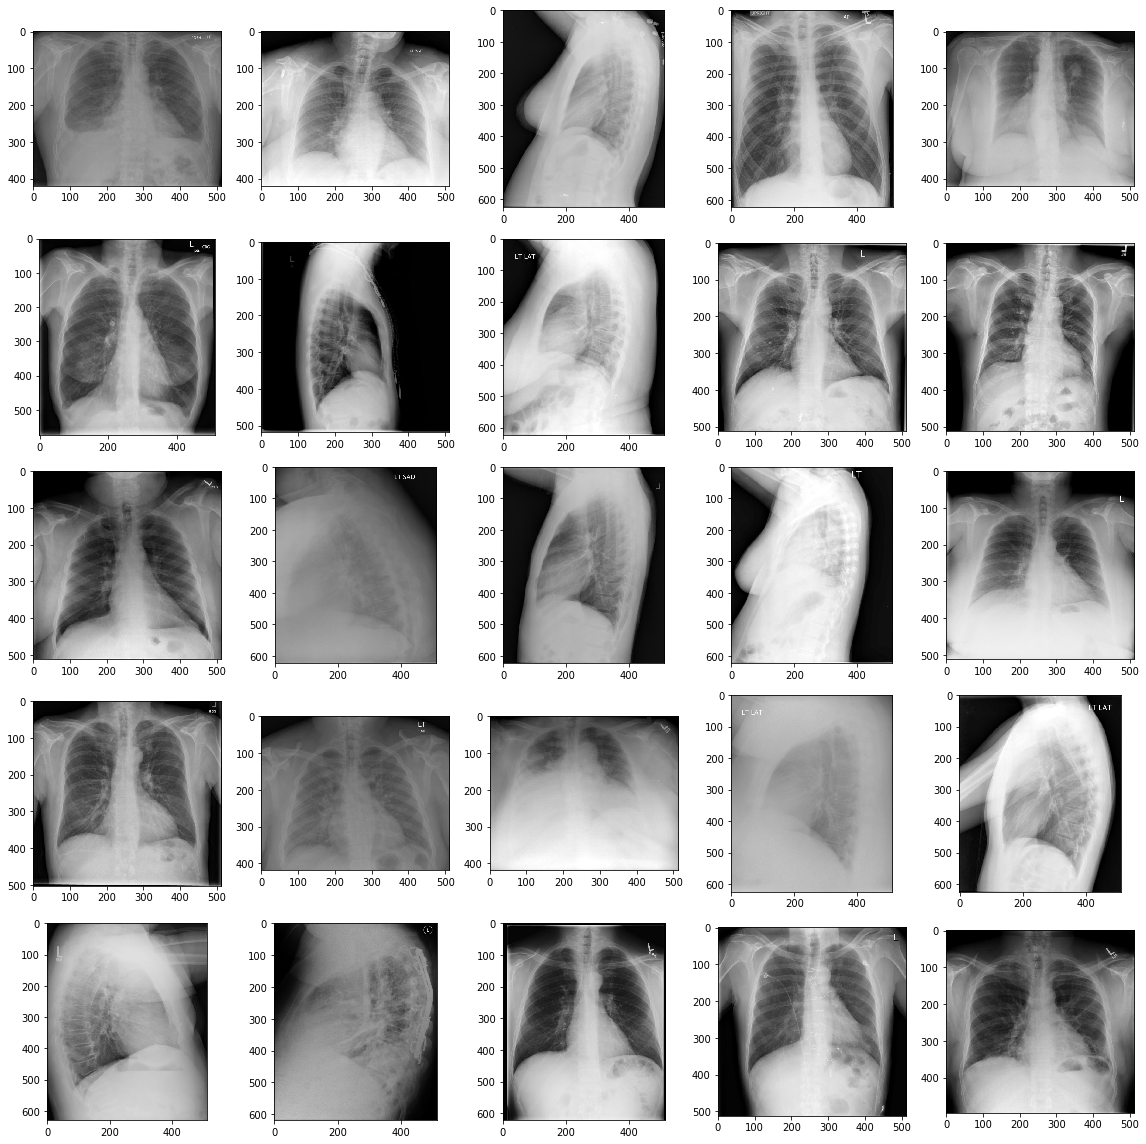

In [176]:
print("==== Displaying worst case result random 25 patient X-Ray 1st image ====")
fig, axs = plt.subplots(5, 5, figsize = (16,16), tight_layout=True)
for row, subplot in zip(df_poor_zero[0:25].itertuples(), axs.flatten()):
    img=mpimg.imread(image_path+row.image_1)
    subplot.imshow(img, cmap = 'bone')
plt.show()

__points to take in wors case__
- images are shadowed in some case (row, column) (3,2),(3,4),(4,2),(4,3),(4,4)
- images are too bright in some case (1,2),(3,4),(5,3)
- Lets see both images in a data point to check whether any one have those above issue.

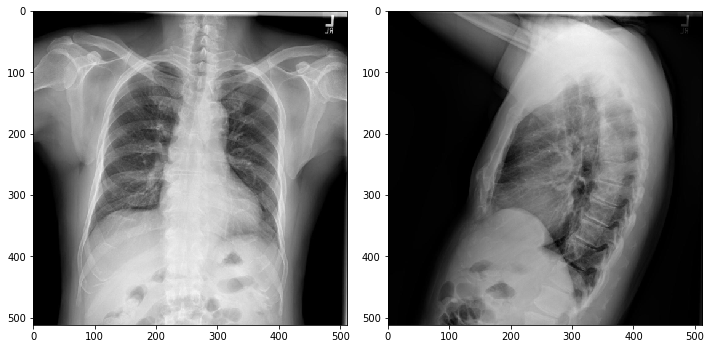

Score: 0.0
Actual: no evidence of active disease
Predicted: low lung features
word count: 5


In [193]:
import random
k=random.choice(df_poor_zero.index.tolist())
img_nms = [df_poor_zero["image_1"][k], df_poor_zero["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score:", df_poor_zero["score"][k])
print("Actual:", df_poor_zero["actual"][k])
print("Predicted:", df_poor_zero["predicted"][k])
print("word count:", df_poor_zero["actual_count"][k])

- In this data point we see the second image is not properly taken. there is finger prints visible in the bottom of the picture, major error.

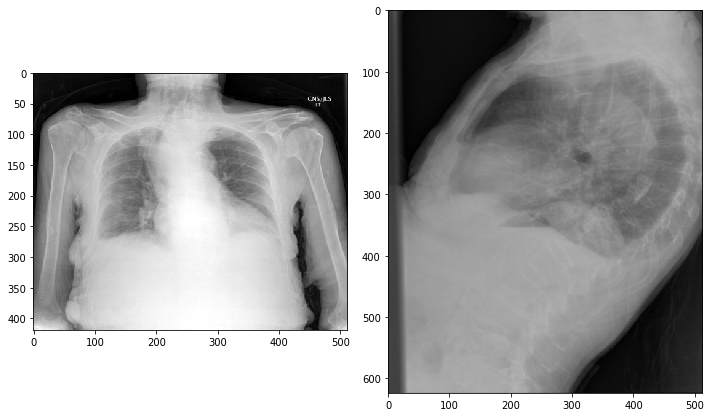

Score:  0.0
Actual:  bilateral small pleural effusions and associated atelectasis stable right upper mediastinal opacity consistent with goiter
Predicted:  no acute cardiopulmonary abnormality


In [68]:
k=random.choice(df_poor_zero.index.tolist())
img_nms = [df_poor_zero["image_1"][k], df_poor_zero["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score: ", df_poor_zero["score"][k])
print("Actual: ", df_poor_zero["actual"][k])
print("Predicted: ", df_poor_zero["predicted"][k])

- Clear view of poor xray capturing also covered the hands
- right side image have addition dark stripes in the lower left edge

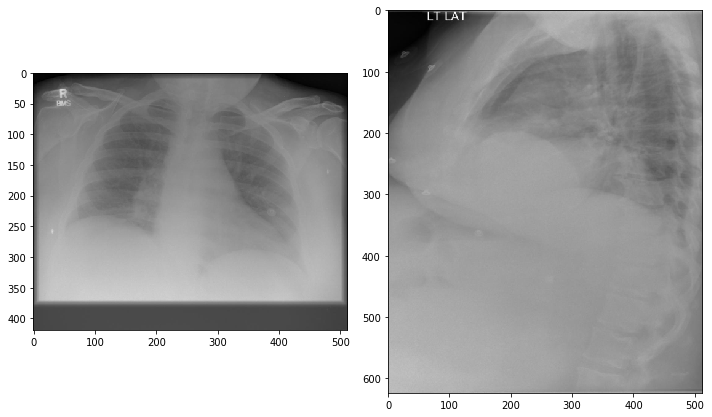

Score:  0.0
Actual:  mild central vascular prominence congestion heart size at the upper limits of normal
Predicted:  no acute cardiopulmonary abnormality


In [103]:
k=random.choice(df_poor_zero.index.tolist())
img_nms = [df_poor_zero["image_1"][k], df_poor_zero["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score: ", df_poor_zero["score"][k])
print("Actual: ", df_poor_zero["actual"][k])
print("Predicted: ", df_poor_zero["predicted"][k])

- Clear view of Poor image quality

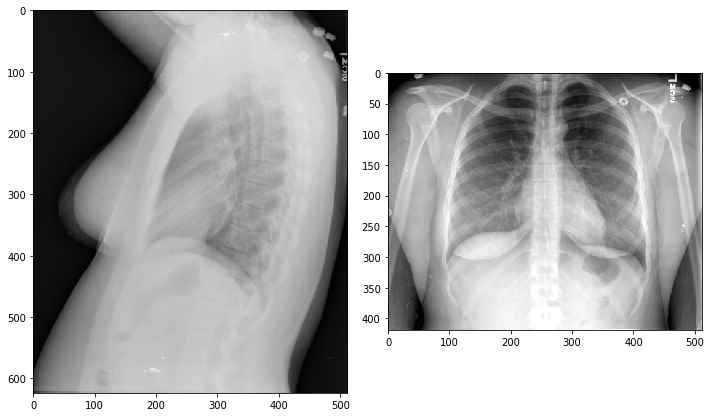

Score:  0.0
Actual:  normal chest
Predicted:  no acute findings


In [29]:
k=random.choice(df_poor_zero.index.tolist())
img_nms = [df_poor_zero["image_1"][k], df_poor_zero["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score: ", df_poor_zero["score"][k])
print("Actual: ", df_poor_zero["actual"][k])
print("Predicted: ", df_poor_zero["predicted"][k])

- could not find any image quality issue. but the word meanings are same.

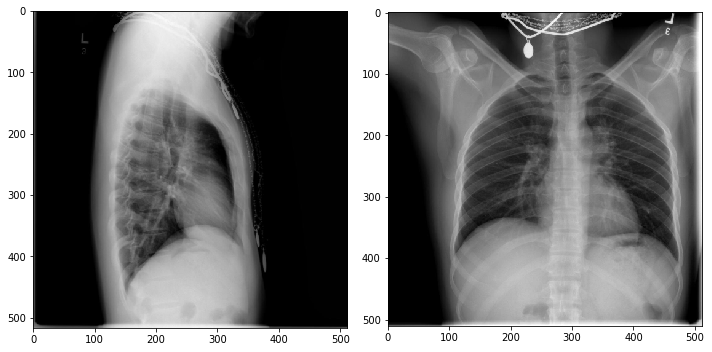

Score:  0.0
Actual:  no acute findings
Predicted:  low lung effusion


In [26]:
k=random.choice(df_poor_zero.index.tolist())
img_nms = [df_poor_zero["image_1"][k], df_poor_zero["image_2"][k]]
fig, axs = plt.subplots(1, len(img_nms), figsize = (10,10), tight_layout=True)
count = 0
for img, subplot in zip(img_nms, axs.flatten()):
    img_=mpimg.imread(image_path+img)
    imgplot = axs[count].imshow(img_, cmap = 'bone')
    count +=1
plt.show()
print("Score: ", df_poor_zero["score"][k])
print("Actual: ", df_poor_zero["actual"][k])
print("Predicted: ", df_poor_zero["predicted"][k])

- clear view of poor image quality. x-ray with Jewellery in both images this is not found in any x-rays even in the x-ray classification task dataset.  

# Conclusion
- From the above analysis we have found that the quality of the images is plays major role. Mostly the error data points are with poor images quality poor chest bone view this is the primary take away.
- we have also seen some finger prints, jewellery of the patient clearly visible in the image.
- the model works well on the clear visible chest bones. we have already seen this and compared in the best and worst case images.
- there are images which are brighter those cases model fails. we have also seen the best result images where we does not have the brighter images. brighter means higher white pixels.
- Another finding is that our model did not perform well in the case where we have more than 20 words. we could able to improve this by changing the architecture. better than this but our model does not shows that its poor model. error are 62 out of 399 which is almost 15% of the data. does not show it is poor prediction.
- some case where we have incorrect words in true sentence.
- we could ignore theses error in our future work to get the better performance.